##Modelo TCN para filtro pasa alto

Subir Dataset

In [ ]:
import torch
import numpy as np

from google.colab import drive
drive.mount('/content/drive')
data_path = '/content/drive/MyDrive/kaspix_training_data_hpf.pt'
data = torch.load(data_path, weights_only=False)

# Ver composición
print("Composición del Dataset")
print(f"Claves disponibles: {data.keys()}")
print(f"N de muestras: {len(data['x'])}")

# Ver dimensiones de una muestra
sample_x = data['x'][0]
sample_y = data['y'][0]

print("\n Dimensiones de una muestra")
print(f"Audio entrada: {sample_x['audio_in'].shape}") # Debería ser (n_samples,)
print(f"Audio salida: {sample_y.shape}")            # Debería ser (n_samples,)
print(f"Cantidad de Knobs: {len(sample_x['knobs'])}")
print(f"Knobs: {sample_x['knob_names']}")

Mounted at /content/drive
Composición del Dataset
Claves disponibles: dict_keys(['x', 'y', 'fs', 'meta', 'recipe', 'seed'])
N de muestras: 20000

 Dimensiones de una muestra
Audio entrada: (960,)
Audio salida: (960,)
Cantidad de Knobs: 3
Knobs: ['R_gain', 'C_hp', 'R_load']


DataLoader

In [ ]:
from IPython.testing import test
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split

class KaspixDataset(Dataset):
    def __init__(self, data_path):
        # Cargamos con weights_only=False por los arrays de numpy
        checkpoint = torch.load(data_path, weights_only=False)

        # Extraemos y convertimos a tensores
        # [Batch, Channels, Samples] -> [20000, 1, 960]
        self.x_audio = torch.stack([
            torch.from_numpy(item['audio_in']).float().unsqueeze(0)
            for item in checkpoint['x']])
        self.x_knobs = torch.stack([
            torch.from_numpy(item['knobs']).float()
            for item in checkpoint['x']])
        self.y = torch.stack([
            torch.from_numpy(item).float().unsqueeze(0)
            for item in checkpoint['y']])

        self.knob_mean = self.x_knobs.mean(dim=0, keepdim=True)
        self.knob_std = self.x_knobs.std(dim=0, keepdim=True)
        self.x_knobs = (self.x_knobs - self.knob_mean) / (self.knob_std + 1e-8)

        print(f"Dataset cargado: {self.x_audio.shape[0]} muestras de {self.x_audio.shape[2]} samples.")

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.x_audio[idx], self.x_knobs[idx], self.y[idx]

# Cargar y dividir (80% tren, 10% val, 10% test)
full_ds = KaspixDataset(data_path)
knob_mean = full_ds.x_knobs.mean(dim=0)
knob_std = full_ds.x_knobs.std(dim=0)
total_samples = len(full_ds)
train_size = int(0.8 * total_samples)
val_size = int(0.1 * total_samples)
test_size = total_samples - train_size - val_size
train_ds, val_ds, test_ds = random_split(full_ds, [train_size, val_size, test_size],
                                         generator=torch.Generator().manual_seed(42))

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=64, shuffle=False, drop_last=True)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

Dataset cargado: 20000 muestras de 960 samples.


Arquitectura

In [ ]:
class FiLM(nn.Module):
    def __init__(self, channels, knob_dim):
        super().__init__()
        self.gen = nn.Linear(knob_dim, channels * 2)

    def forward(self, x, knobs):
        params = self.gen(knobs).unsqueeze(2)
        gamma, beta = torch.chunk(params, 2, dim=1)
        return x * gamma + beta

class TCN(nn.Module):
    def __init__(self, in_ch, out_ch, kernel_size, dilation, knob_dim):
        super().__init__()
        self.padding = (kernel_size - 1) * dilation
        self.conv = nn.Conv1d(in_ch, out_ch, kernel_size,
                              padding=self.padding,
                              dilation=dilation)
        self.film = FiLM(out_ch, knob_dim)
        self.act = nn.PReLU()
        self.norm = nn.GroupNorm(1, out_ch)
        self.res = nn.Conv1d(in_ch, out_ch, 1) if in_ch != out_ch else nn.Identity()

    def forward(self, x, knobs):
        res = self.res(x)
        x = self.conv(x)

        if self.padding > 0:
            x = x[:, :, :-self.padding]

        x = self.film(x, knobs)
        x = self.norm(x)
        return self.act(x) + res

class KaspixTCN(nn.Module):
    def __init__(self, num_knobs=3):
        super().__init__()

        self.channels = 64
        self.num_layers = 12
        self.layers = nn.ModuleList()
        self.layers.append(TCN(1, self.channels, 3, 1, num_knobs))

        for i in range(1, self.num_layers):
            dilation = 2 ** i
            self.layers.append(TCN(self.channels, self.channels, 3, dilation, num_knobs))

        self.output = nn.Conv1d(self.channels, 1, kernel_size=1)

    def forward(self, audio, knobs):
        x = audio
        for layer in self.layers:
            x = layer(x, knobs)
        return self.output(x)

Entrenamiento inicial

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import r2_score
from tqdm.auto import tqdm
import numpy as np

def calculate_esr(pred, target):
    return torch.sum((target - pred)**2) / (torch.sum(target**2) + 1e-9)

def calculate_lsd(pred, true, fs=44100):
    Y_true = torch.fft.rfft(true, dim=-1).abs() + 1e-8
    Y_pred = torch.fft.rfft(pred, dim=-1).abs() + 1e-8
    log_diff = torch.log10(Y_true ** 2) - torch.log10(Y_pred ** 2)
    lsd = torch.sqrt(torch.mean(log_diff ** 2, dim=-1))
    return torch.mean(lsd)

# 2. Configuración de hardware
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
checkpoint_path = 'best_kaspix_filtros_pa.pth'
num_imputs_knobs = full_ds.x_knobs.shape[1]

# 3. Inicializar modelo
model = KaspixTCN(num_knobs=num_imputs_knobs).to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=3)
criterion = nn.MSELoss()

print(f" Iniciando entrenamiento con REALISMO FÍSICO en {device}...")

best_score = float('inf')
patience_counter = 0
patience = 15
epochs = 50

# 4. Bucle de entrenamiento
for epoch in range(epochs):
    model.train()
    train_loss = 0
    pbar = tqdm(train_loader, desc=f"Época {epoch+1}/{epochs}", leave=False)

    for x_audio, x_knobs, y_true in pbar:
        x_audio, x_knobs, y_true = x_audio.to(device), x_knobs.to(device), y_true.to(device)

        optimizer.zero_grad()
        y_pred = model(x_audio, x_knobs)
        loss = criterion(y_pred, y_true)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=5.0)
        optimizer.step()

        train_loss += loss.item()
        with torch.no_grad():
            esr = calculate_esr(y_pred, y_true)
            lsd_val = calculate_lsd(y_pred, y_true)
        pbar.set_postfix(loss=f"{loss.item():.6f}", esr=f"{esr.item():.6f}", lsd=f"{lsd_val.item():.4f}")

    # 5. Fase de Validación (También con realismo para evaluar robustez)
    model.eval()
    val_mse, val_esr, val_lsd = 0, 0, 0

    with torch.no_grad():
        for x_a, x_k, y_t in val_loader:
            x_a, x_k, y_t = x_a.to(device), x_k.to(device), y_t.to(device)
            y_p = model(x_a, x_k)

            val_mse += criterion(y_p, y_t).item()
            val_esr += calculate_esr(y_p, y_t).item()
            val_lsd += calculate_lsd(y_p, y_t).item()

            y_t_flat = y_t.cpu().numpy().flatten()
            y_p_flat = y_p.cpu().numpy().flatten()

    avg_mse = val_mse / len(val_loader)
    avg_esr = val_esr / len(val_loader)
    avg_lsd = val_lsd / len(val_loader)

    scheduler.step(avg_mse)
    score_actual = avg_esr + (avg_lsd / 10)

    print(f"\n Época {epoch+1} finalizada. MSE: {avg_mse:.6f} | ESR: {avg_esr:.6f} | LSD: {avg_lsd:.6f}")

    # 6. Guardado del mejor modelo
    if score_actual < best_score:
        best_score = score_actual
        patience_counter = 0
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'val_mse': avg_mse,
            'val_esr': avg_esr,
            'val_lsd': avg_lsd,
            'best_score': best_score
            }, checkpoint_path)
        print(f" Nuevo Récord! Score: {score_actual:.6f} (ESR: {avg_esr:.6f} | LSD: {avg_lsd:.6f}) ")
    else:
        patience_counter += 1

    if patience_counter >= patience:
        break

print(f" Entrenamiento finalizado. Best score: {best_score:.6f}")

 Iniciando entrenamiento con REALISMO FÍSICO en cuda...


Época 1/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 1 finalizada. MSE: 0.005184 | ESR: 0.104170 | LSD: 0.444556
 Nuevo Récord! Score: 0.148625 (ESR: 0.1042 | LSD: 0.4446) 


Época 2/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 2 finalizada. MSE: 0.003800 | ESR: 0.077000 | LSD: 0.386340
 Nuevo Récord! Score: 0.115634 (ESR: 0.0770 | LSD: 0.3863) 


Época 3/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 3 finalizada. MSE: 0.002222 | ESR: 0.044684 | LSD: 0.351068
 Nuevo Récord! Score: 0.079791 (ESR: 0.0447 | LSD: 0.3511) 


Época 4/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 4 finalizada. MSE: 0.002603 | ESR: 0.053228 | LSD: 0.348790


Época 5/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 5 finalizada. MSE: 0.003330 | ESR: 0.068326 | LSD: 0.337059


Época 6/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 6 finalizada. MSE: 0.002430 | ESR: 0.049618 | LSD: 0.328060


Época 7/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 7 finalizada. MSE: 0.001565 | ESR: 0.031707 | LSD: 0.313457
 Nuevo Récord! Score: 0.063053 (ESR: 0.0317 | LSD: 0.3135) 


Época 8/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 8 finalizada. MSE: 0.001349 | ESR: 0.027213 | LSD: 0.297501
 Nuevo Récord! Score: 0.056963 (ESR: 0.0272 | LSD: 0.2975) 


Época 9/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 9 finalizada. MSE: 0.001928 | ESR: 0.039419 | LSD: 0.302036


Época 10/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 10 finalizada. MSE: 0.001269 | ESR: 0.025777 | LSD: 0.295769
 Nuevo Récord! Score: 0.055354 (ESR: 0.0258 | LSD: 0.2958) 


Época 11/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 11 finalizada. MSE: 0.001786 | ESR: 0.036630 | LSD: 0.298379


Época 12/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 12 finalizada. MSE: 0.001208 | ESR: 0.024550 | LSD: 0.289414
 Nuevo Récord! Score: 0.053492 (ESR: 0.0246 | LSD: 0.2894) 


Época 13/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 13 finalizada. MSE: 0.001460 | ESR: 0.029898 | LSD: 0.294400


Época 14/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 14 finalizada. MSE: 0.001039 | ESR: 0.021147 | LSD: 0.280068
 Nuevo Récord! Score: 0.049154 (ESR: 0.0211 | LSD: 0.2801) 


Época 15/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 15 finalizada. MSE: 0.001039 | ESR: 0.021210 | LSD: 0.281265


Época 16/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 16 finalizada. MSE: 0.000968 | ESR: 0.019750 | LSD: 0.270480
 Nuevo Récord! Score: 0.046799 (ESR: 0.0198 | LSD: 0.2705) 


Época 17/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 17 finalizada. MSE: 0.001091 | ESR: 0.022232 | LSD: 0.278880


Época 18/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 18 finalizada. MSE: 0.001683 | ESR: 0.034657 | LSD: 0.279315


Época 19/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 19 finalizada. MSE: 0.001128 | ESR: 0.023123 | LSD: 0.274895


Época 20/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 20 finalizada. MSE: 0.000957 | ESR: 0.019662 | LSD: 0.266654
 Nuevo Récord! Score: 0.046328 (ESR: 0.0197 | LSD: 0.2667) 


Época 21/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 21 finalizada. MSE: 0.001174 | ESR: 0.024066 | LSD: 0.270933


Época 22/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 22 finalizada. MSE: 0.000821 | ESR: 0.016883 | LSD: 0.263149
 Nuevo Récord! Score: 0.043198 (ESR: 0.0169 | LSD: 0.2631) 


Época 23/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 23 finalizada. MSE: 0.000956 | ESR: 0.019729 | LSD: 0.263486


Época 24/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 24 finalizada. MSE: 0.000973 | ESR: 0.020110 | LSD: 0.260872


Época 25/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 25 finalizada. MSE: 0.002101 | ESR: 0.043650 | LSD: 0.268475


Época 26/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 26 finalizada. MSE: 0.000745 | ESR: 0.015410 | LSD: 0.252015
 Nuevo Récord! Score: 0.040611 (ESR: 0.0154 | LSD: 0.2520) 


Época 27/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 27 finalizada. MSE: 0.001039 | ESR: 0.021416 | LSD: 0.259296


Época 28/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 28 finalizada. MSE: 0.000729 | ESR: 0.015101 | LSD: 0.252722
 Nuevo Récord! Score: 0.040373 (ESR: 0.0151 | LSD: 0.2527) 


Época 29/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 29 finalizada. MSE: 0.001891 | ESR: 0.039014 | LSD: 0.260644


Época 30/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 30 finalizada. MSE: 0.000712 | ESR: 0.014805 | LSD: 0.245539
 Nuevo Récord! Score: 0.039358 (ESR: 0.0148 | LSD: 0.2455) 


Época 31/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 31 finalizada. MSE: 0.000650 | ESR: 0.013519 | LSD: 0.247962
 Nuevo Récord! Score: 0.038315 (ESR: 0.0135 | LSD: 0.2480) 


Época 32/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 32 finalizada. MSE: 0.000914 | ESR: 0.019007 | LSD: 0.255666


Época 33/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 33 finalizada. MSE: 0.000722 | ESR: 0.015074 | LSD: 0.247556


Época 34/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 34 finalizada. MSE: 0.001158 | ESR: 0.024195 | LSD: 0.253357


Época 35/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 35 finalizada. MSE: 0.001204 | ESR: 0.025020 | LSD: 0.255466


Época 36/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 36 finalizada. MSE: 0.000614 | ESR: 0.012834 | LSD: 0.248581
 Nuevo Récord! Score: 0.037692 (ESR: 0.0128 | LSD: 0.2486) 


Época 37/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 37 finalizada. MSE: 0.000542 | ESR: 0.011401 | LSD: 0.242906
 Nuevo Récord! Score: 0.035692 (ESR: 0.0114 | LSD: 0.2429) 


Época 38/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 38 finalizada. MSE: 0.000545 | ESR: 0.011487 | LSD: 0.244479


Época 39/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 39 finalizada. MSE: 0.000535 | ESR: 0.011299 | LSD: 0.243902
 Nuevo Récord! Score: 0.035689 (ESR: 0.0113 | LSD: 0.2439) 


Época 40/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 40 finalizada. MSE: 0.000537 | ESR: 0.011325 | LSD: 0.244618


Época 41/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 41 finalizada. MSE: 0.000561 | ESR: 0.011855 | LSD: 0.249551


Época 42/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 42 finalizada. MSE: 0.000527 | ESR: 0.011171 | LSD: 0.244890
 Nuevo Récord! Score: 0.035659 (ESR: 0.0112 | LSD: 0.2449) 


Época 43/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 43 finalizada. MSE: 0.000508 | ESR: 0.010783 | LSD: 0.244223
 Nuevo Récord! Score: 0.035205 (ESR: 0.0108 | LSD: 0.2442) 


Época 44/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 44 finalizada. MSE: 0.001545 | ESR: 0.032143 | LSD: 0.261444


Época 45/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 45 finalizada. MSE: 0.000514 | ESR: 0.010923 | LSD: 0.244023


Época 46/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 46 finalizada. MSE: 0.000496 | ESR: 0.010530 | LSD: 0.242912
 Nuevo Récord! Score: 0.034821 (ESR: 0.0105 | LSD: 0.2429) 


Época 47/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 47 finalizada. MSE: 0.000485 | ESR: 0.010346 | LSD: 0.243838
 Nuevo Récord! Score: 0.034730 (ESR: 0.0103 | LSD: 0.2438) 


Época 48/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 48 finalizada. MSE: 0.000458 | ESR: 0.009801 | LSD: 0.241428
 Nuevo Récord! Score: 0.033944 (ESR: 0.0098 | LSD: 0.2414) 


Época 49/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 49 finalizada. MSE: 0.000528 | ESR: 0.011211 | LSD: 0.246182


Época 50/50:   0%|          | 0/250 [00:00<?, ?it/s]


 Época 50 finalizada. MSE: 0.000534 | ESR: 0.011325 | LSD: 0.247223
 Entrenamiento finalizado. Best score: 0.0339436708


Gráficos

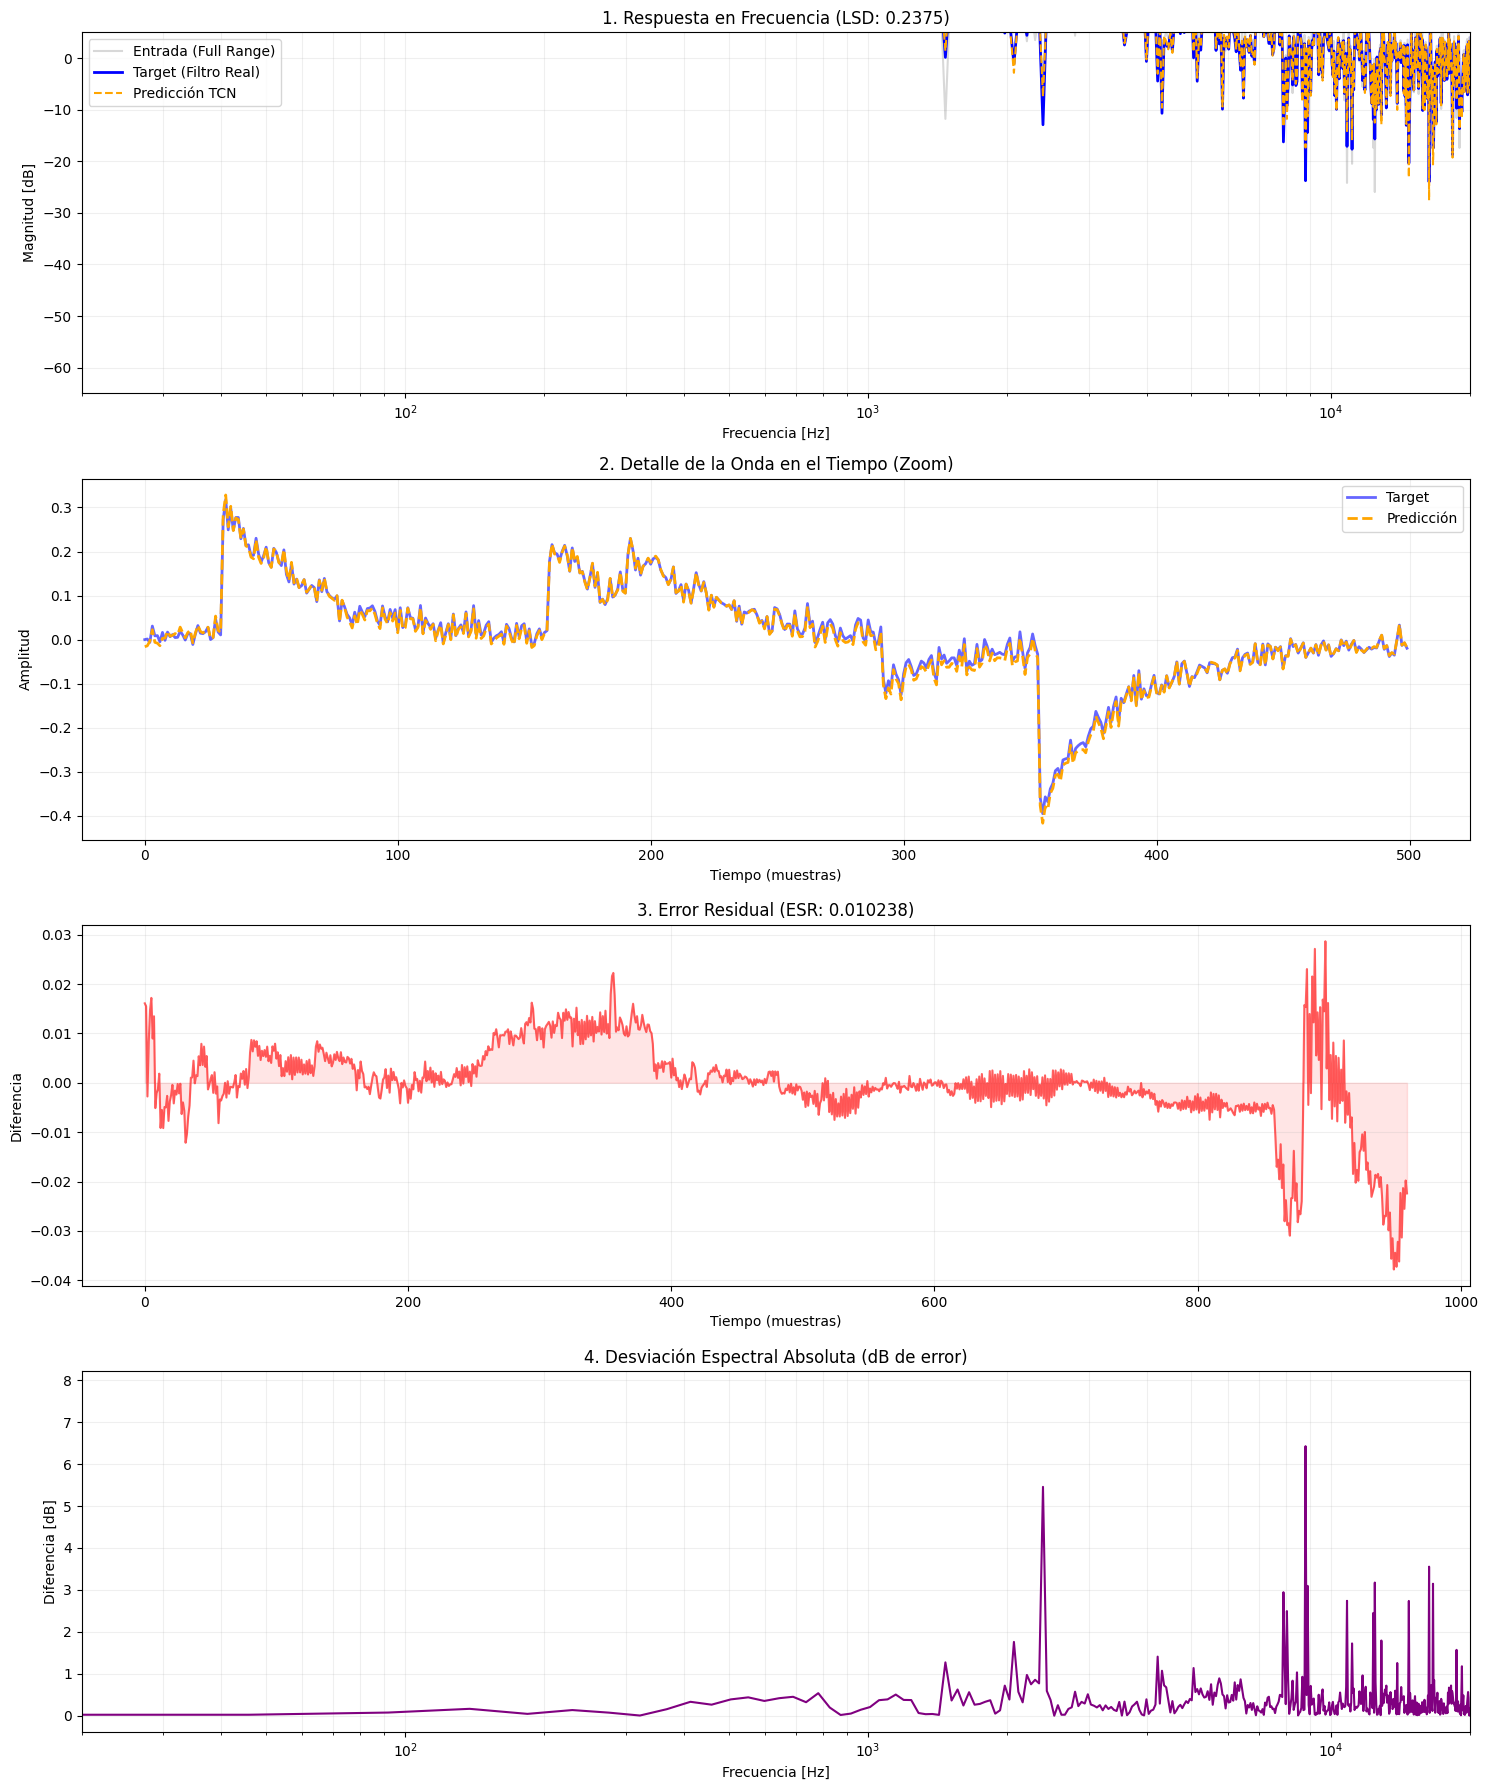

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt

# 1. Preparar el modelo y cargar pesos
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_inputs_knobs = val_ds.dataset.x_knobs.shape[1]

model = KaspixTCN(num_knobs=num_inputs_knobs).to(device)
checkpoint = torch.load('best_kaspix_filtros_pa.pth', map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

# 2. Extraer una muestra de validación
sample_idx = 123
x_audio, x_knobs, y_true = val_ds[sample_idx]
x_audio_t = x_audio.unsqueeze(0).to(device)
x_knobs_t = x_knobs.unsqueeze(0).to(device)

with torch.no_grad():
    y_pred_t = model(x_audio_t, x_knobs_t)

# 3. Conversión a numpy para visualización
y_true_np = y_true.squeeze().cpu().numpy()
y_pred_np = y_pred_t.squeeze().cpu().numpy()
x_in_np = x_audio.squeeze().cpu().numpy()

# --- DASHBOARD DE RESULTADOS ---
plt.figure(figsize=(15, 18))

# A. RESPUESTA EN FRECUENCIA (FFT)
plt.subplot(4, 1, 1)
def get_magnitude_db(sig):
    return 20 * np.log10(np.abs(np.fft.rfft(sig)) + 1e-8)

freqs = np.fft.rfftfreq(len(y_true_np), 1/44100)
plt.plot(freqs, get_magnitude_db(x_in_np), color='gray', alpha=0.3, label='Entrada (Full Range)')
plt.plot(freqs, get_magnitude_db(y_true_np), color='blue', lw=2, label='Target (Filtro Real)')
plt.plot(freqs, get_magnitude_db(y_pred_np), color='orange', ls='--', label='Predicción TCN')
plt.xscale('log')
plt.xlim(20, 20000)
plt.ylim(-65, 5)
plt.title(f"1. Respuesta en Frecuencia (LSD: {checkpoint.get('val_lsd', 0):.4f})")
plt.ylabel("Magnitud [dB]")
plt.xlabel("Frecuencia [Hz]")
plt.legend()
plt.grid(True, which="both", alpha=0.2)

# B. ZOOM FORMA DE ONDA (Tiempo)
plt.subplot(4, 1, 2)
# Mostramos un fragmento central para ver la fase y amplitud
plt.plot(y_true_np[:500], label='Target', color='blue', alpha=0.6, lw=2)
plt.plot(y_pred_np[:500], label='Predicción', color='orange', ls='--', lw=2)
plt.title("2. Detalle de la Onda en el Tiempo (Zoom)")
plt.xlabel("Tiempo (muestras)")
plt.ylabel("Amplitud")
plt.legend()
plt.grid(True, alpha=0.2)

# C. ERROR RESIDUAL
plt.subplot(4, 1, 3)
error = y_true_np - y_pred_np
plt.plot(error, color='red', alpha=0.6)
plt.title(f"3. Error Residual (ESR: {checkpoint.get('val_esr', 0):.6f})")
plt.fill_between(range(len(error)), error, color='red', alpha=0.1)
plt.xlabel("Tiempo (muestras)")
plt.ylabel("Diferencia")
plt.grid(True, alpha=0.2)

# D. ERROR POR FRECUENCIA
plt.subplot(4, 1, 4)
diff_db = np.abs(get_magnitude_db(y_true_np) - get_magnitude_db(y_pred_np))
plt.plot(freqs, diff_db, color='purple')
plt.xscale('log')
plt.xlim(20, 20000)
plt.title("4. Desviación Espectral Absoluta (dB de error)")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Diferencia [dB]")
plt.grid(True, which="both", alpha=0.2)

plt.tight_layout()
plt.show()

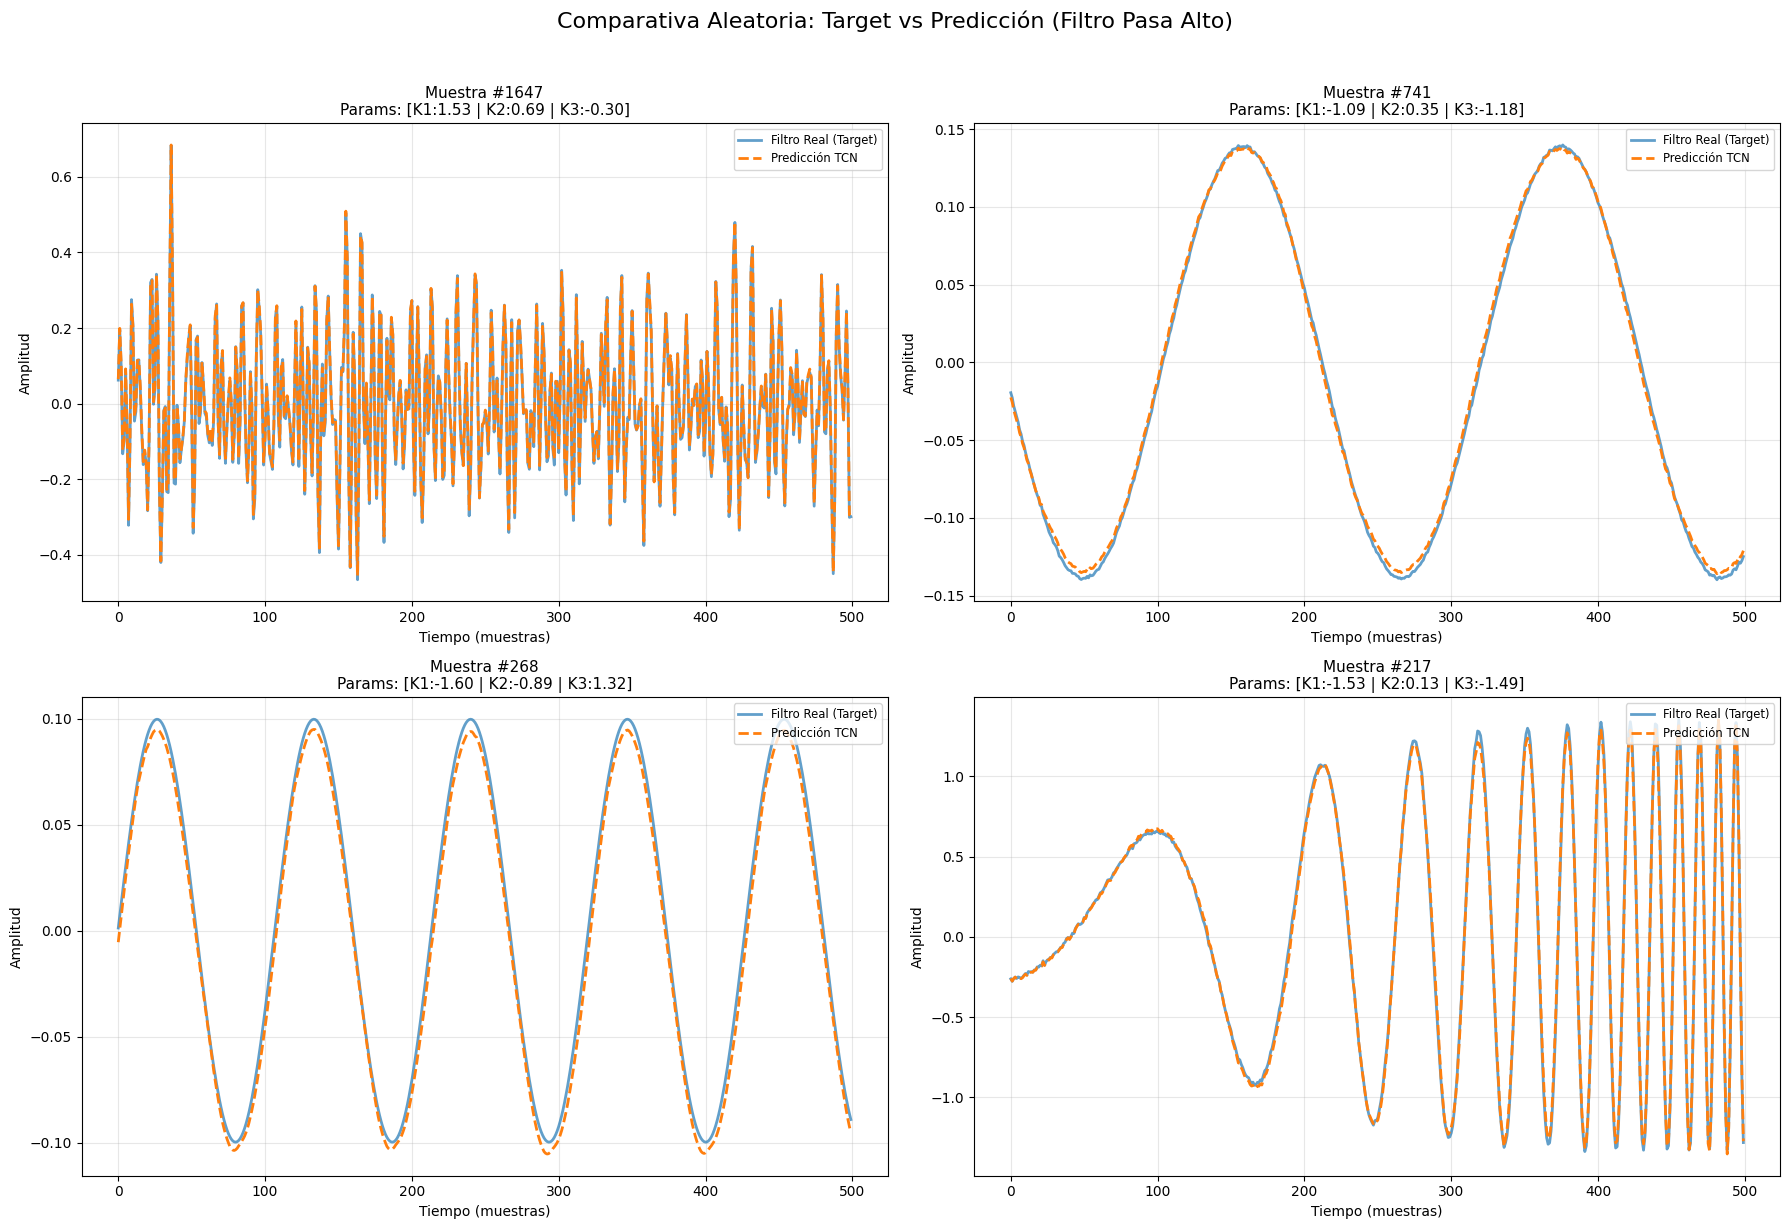

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import random

def visualizar_comparativa_pasa_alto(model, dataset, device):
    model.eval()
    # Creamos una cuadrícula de 2x2 para que sea más fácil comparar
    fig, axes = plt.subplots(2, 2, figsize=(18, 12))
    axes = axes.flatten()
    plt.subplots_adjust(hspace=0.4, wspace=0.2)

    # Seleccionamos 4 índices aleatorios del conjunto de validación o test
    indices = random.sample(range(len(dataset)), 4)

    with torch.no_grad():
        for i, idx in enumerate(indices):
            # 1. Extraer datos del Subset de forma segura
            x_audio, x_knobs, y_true = dataset[idx]

            # 2. Preparar Tensores [Batch, Canales, Samples]
            x_audio_t = x_audio.unsqueeze(0).to(device)
            x_knobs_t = x_knobs.unsqueeze(0).to(device)

            # 3. Inferencia
            y_pred_t = model(x_audio_t, x_knobs_t)

            # 4. Pasar a Numpy
            y_true_np = y_true.squeeze().cpu().numpy()
            y_pred_np = y_pred_t.squeeze().cpu().numpy()
            knobs_vals = x_knobs.cpu().numpy()

            # 5. Graficar Forma de Onda (Dominio del Tiempo)
            ax = axes[i]
            # Hacemos zoom en un fragmento con actividad (muestras 300 a 800)
            start, end = 300, 800

            ax.plot(y_true_np[start:end], label='Filtro Real (Target)', color='#1f77b4', lw=2, alpha=0.7)
            ax.plot(y_pred_np[start:end], label='Predicción TCN', color='#ff7f0e', ls='--', lw=2)

            # Formatear etiquetas de los Knobs (asumiendo los 3 originales de tu Pasa Alto)
            knobs_label = " | ".join([f"K{j+1}:{v:.2f}" for j, v in enumerate(knobs_vals)])

            ax.set_title(f"Muestra #{idx}\nParams: [{knobs_label}]", fontsize=11)
            ax.set_xlabel("Tiempo (muestras)")
            ax.set_ylabel("Amplitud")
            ax.legend(loc='upper right', fontsize='small')
            ax.grid(True, alpha=0.3)

    plt.suptitle("Comparativa Aleatoria: Target vs Predicción (Filtro Pasa Alto)", fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()

# --- EJECUCIÓN ---
# Asegúrate de usar el modelo que entrenaste para 3 knobs y el dataset correspondiente
visualizar_comparativa_pasa_alto(model, val_ds, device)